In [3]:
import json, sys, os, glob, re
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [4]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *                       
from etl import *

In [42]:
dir_ = 'data/raw/train_c'
the_csv_youre_using = listdir(dir_)[0] # gets first file you have in `data/raw/train_c` directory
print(the_csv_youre_using)

mergedtable = readfilerun_simple(os.path.join(dir_, the_csv_youre_using), dir_) # merges losslog. make sure you have losslog in the same train_c directory
df = genfeat(mergedtable.copy()) # generates all the adjacent features we train on!
df

20220201T010740_200-100-true-200-10000-200-iperf.csv


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,total_pkts,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,12,13724,11,0.000000,0,1,13724,1143.666667,0,1143.666667
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,60,52520,3,13.694915,402,8,52520,875.333333,808,875.333333
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,56,43456,2,7.400000,399,9,43456,776.000000,407,776.000000
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,65,64196,3,12.656250,400,11,64196,987.630769,810,987.630769
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,42,42728,2,9.878049,399,7,42728,1017.333333,405,1017.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,1671,1831732,10,0.583234,33,243,1831732,1096.189108,974,1096.189108
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,1470,1598288,7,0.675970,36,199,1598288,1087.270748,993,1087.270748
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,2002,2189224,8,0.493253,34,223,2189224,1093.518482,987,1093.518482
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,1771,1907884,8,0.554802,35,210,1907884,1077.291925,982,1077.291925


In [6]:
df[['loss', 'latency', 'switch_label']] # labels!

,loss,latency,switch_label
0,100,200,200
1,100,200,200
2,100,200,200
4,100,200,200
5,100,200,200
...,...,...,...
303,10000,200,200
304,10000,200,200
305,10000,200,200
306,10000,200,200


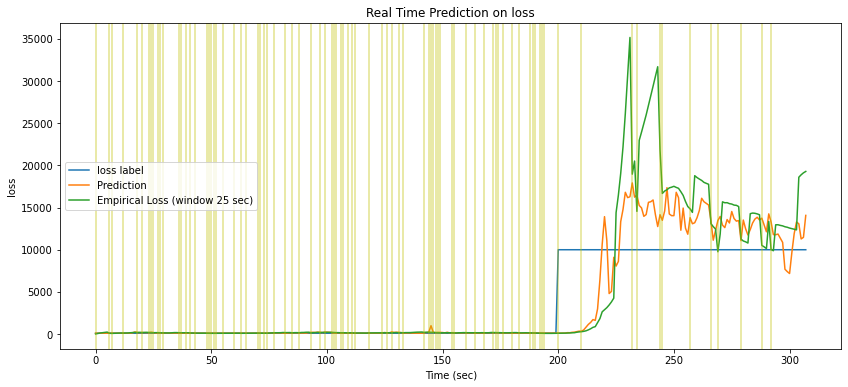

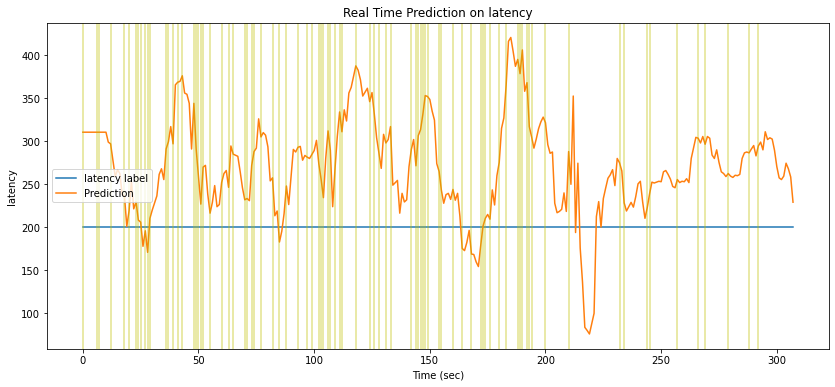

In [7]:
def gen_model(df, label, emplosswindow=25):
    """generates predictive model and outputs predictions to new column in input df"""
    if label == "loss":
        # latency features
        indexcol = ["byte_ratio", "pkt_ratio", "time_spread", "total_bytes", "2->1Pkts"]
    else:
        # loss features
        indexcol = [
            "total_pkts",
            "total_pkt_sizes",
            "2->1Bytes",
            "number_ms",
            "mean_tdelta",
            "max_tdelta",
            "time_spread",
            "longest_seq"
        ]

    ## takes transformed datababy from outputs (should be in gdrive)
    ct = pd.read_csv("outputs/combined_transform.csv").rename(
        {"mean_tdelta.1": "mean_tdelta_amin", "mean_tdelta.2": "mean_tdelta_amax"},
        axis=1,
    )

    X_train, X_test, y_train, y_test = train_test_split(
        ct[[x for x in indexcol if x in df.columns]], ct[label]
    )
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    mdl = RandomForestRegressor(n_estimators=100, n_jobs=4)
    mdl = mdl.fit(X_train, y_train)

    df["prediction"] = mdl.predict(
        df[indexcol].rolling(10).mean().bfill()
    )  # prediction on mean aggregation

    def emp_loss(df, window=25):
        """returns empirical loss of a dataframe with the provided data over a specified window of time."""
        return (
            df["total_pkts"].rolling(window, min_periods=1).sum()
            / df["event"]
            .str.replace("switch", "")
            .str.split(";")
            .str.len()
            .fillna(0)
            .rolling(window, min_periods=1)
            .sum()
        )

    ## plotting performance visual
    # fig = plt.figure()
    df[[label, "prediction"]].plot(
        figsize=(14, 6),
        title=f"Real Time Prediction on {label}",
        xlabel="Time (sec)",
        ylabel=label,
    )
    if label == "loss":
        emp_loss(df, emplosswindow).plot()

    if label == "loss":
        plt.legend(
            [
                f"{label} label",
                "Prediction",
                f"Empirical Loss (window {emplosswindow} sec)",
            ],
            loc="center left",
        )
    else:
        plt.legend(
            [
                f"{label} label",
                "Prediction",
            ],
            loc="center left",
        )
    for i in df[~df["event"].isnull()].index:
        plt.axvline(x=i, color="y", alpha=0.45)

    ## adds new column to df
    df[f"pred_{label}"] = mdl.predict(df[indexcol].rolling(10, min_periods=1).mean())

    return mdl


#
lossmodel = gen_model(df, "loss")
latmodel = gen_model(df, "latency")


In [8]:
df[['loss', 'latency', 'pred_loss', 'pred_latency']]

,loss,latency,pred_loss,pred_latency
0,100,200,712.0,487.5
1,100,200,100.0,472.0
2,100,200,101.5,407.5
4,100,200,109.5,376.5
5,100,200,112.0,356.0
...,...,...,...,...
303,10000,200,13290.0,259.5
304,10000,200,13070.0,274.5
305,10000,200,11280.0,268.0
306,10000,200,11470.0,258.5


In [9]:
# trying to smooth our the wigglies we arent interested in
df[['smoothed_pred_loss', 'smoothed_pred_latency']] = df[['pred_loss', 'pred_latency']].rolling(20,min_periods=1).mean()
df[['smoothed_pred_loss', 'smoothed_pred_latency']]

,smoothed_pred_loss,smoothed_pred_latency
0,712.00,487.500000
1,406.00,479.750000
2,304.50,455.666667
4,255.75,435.875000
5,227.00,419.900000
...,...,...
303,11769.25,285.325000
304,11764.75,285.975000
305,11647.25,285.375000
306,11528.25,283.975000


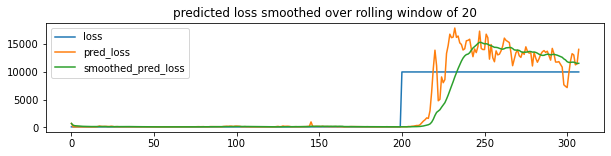

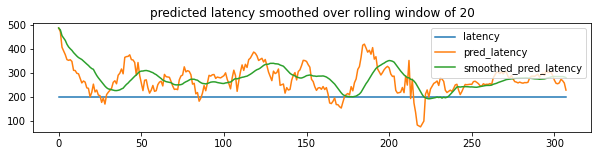

In [10]:
def plot_different_windowsizes(windowsize=20):
    tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
    tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
    tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
    tempdf[['loss', 'pred_loss', 'smoothed_pred_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
    tempdf[['latency', 'pred_latency', 'smoothed_pred_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))
plot_different_windowsizes()

In [11]:
# for i in range(10, 50, 10):
#     plot_different_windowsizes(i)

<AxesSubplot:title={'center':'loss prediction diffs'}>

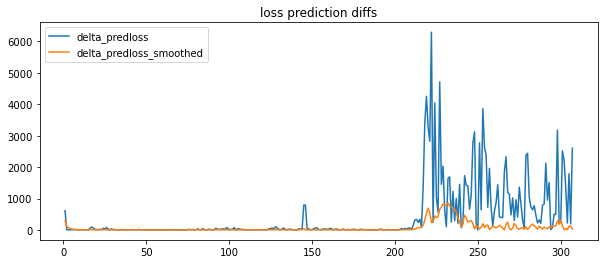

In [12]:
df[['delta_predloss_smoothed', 'delta_predloss']] = df[['smoothed_pred_loss', 'pred_loss']].diff().abs()
df[['delta_predloss', 'delta_predloss_smoothed']].plot(title='loss prediction diffs', figsize=(10,4))

<AxesSubplot:title={'center':'loss prediction diffs'}>

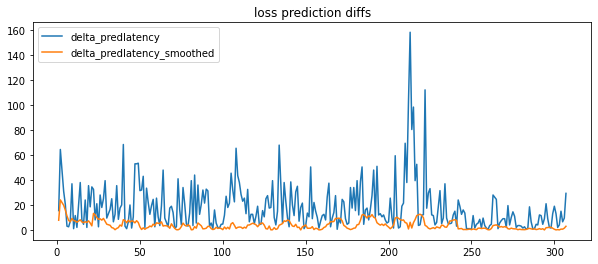

In [13]:
df[['delta_predlatency_smoothed', 'delta_predlatency']] = df[['smoothed_pred_latency', 'pred_latency']].diff().abs()
df[['delta_predlatency', 'delta_predlatency_smoothed']].plot(title='loss prediction diffs', figsize=(10,4))

yeah, probably a good idea to smooth it out or something.

In [14]:
# TODO find that threshold for a significant delta in predictions!
# TODO test this on more interesting dane runs! latency was the same in this analysis.
df

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,byte_ratio,prediction,pred_loss,pred_latency,smoothed_pred_loss,smoothed_pred_latency,delta_predloss_smoothed,delta_predloss,delta_predlatency_smoothed,delta_predlatency
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,1143.666667,310.5,712.0,487.5,712.00,487.500000,NaN,NaN,NaN,NaN
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,875.333333,310.5,100.0,472.0,406.00,479.750000,306.00,612.0,7.750000,15.5
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,776.000000,310.5,101.5,407.5,304.50,455.666667,101.50,1.5,24.083333,64.5
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,987.630769,310.5,109.5,376.5,255.75,435.875000,48.75,8.0,19.791667,31.0
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,1017.333333,310.5,112.0,356.0,227.00,419.900000,28.75,2.5,15.975000,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,1096.189108,259.5,13290.0,259.5,11769.25,285.325000,45.00,1370.0,0.025000,4.0
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,1087.270748,274.5,13070.0,274.5,11764.75,285.975000,4.50,220.0,0.650000,15.0
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,1093.518482,268.0,11280.0,268.0,11647.25,285.375000,117.50,1790.0,0.600000,6.5
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,1077.291925,258.5,11470.0,258.5,11528.25,283.975000,119.00,190.0,1.400000,9.5


<AxesSubplot:>

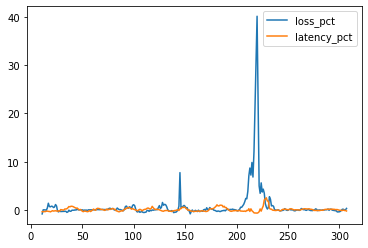

In [15]:
df[['loss_pct', 'latency_pct']] = df[['pred_loss', 'pred_latency']].pct_change(10)
df[['loss_pct', 'latency_pct']].plot()

<AxesSubplot:title={'center':'predicted latency smoothed over rolling window of 10'}>

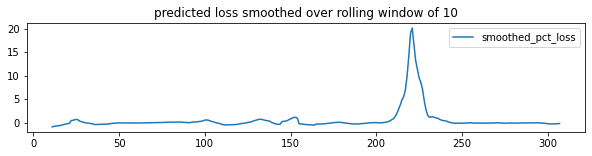

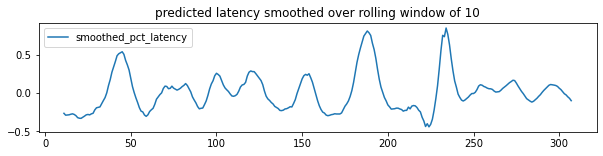

In [16]:
windowsize = 10
tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
tempdf['smoothed_pct_loss'] = tempdf['smoothed_pred_loss'].pct_change(10)
tempdf['smoothed_pct_latency'] = tempdf['smoothed_pred_latency'].pct_change(10)
tempdf[['smoothed_pct_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
tempdf[['smoothed_pct_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))

In [17]:
df[['delta_predloss_smoothed','delta_predlatency_smoothed']].pct_change()

,delta_predloss_smoothed,delta_predlatency_smoothed
0,NaN,NaN
1,NaN,NaN
2,-0.668301,2.107527
4,-0.519704,-0.178201
5,-0.410256,-0.192842
...,...,...
303,4.294118,-0.900000
304,-0.900000,25.000000
305,25.111111,-0.076923
306,0.012766,1.333333


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction,pred_loss,pred_latency
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,0.000000,0,1,13724,1143.666667,0,1143.666667,339.5,681.5,486.0
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,13.694915,402,8,52520,875.333333,808,875.333333,339.5,137.5,453.5
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,7.400000,399,9,43456,776.000000,407,776.000000,339.5,118.0,392.0
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,12.656250,400,11,64196,987.630769,810,987.630769,339.5,101.5,387.5
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,9.878049,399,7,42728,1017.333333,405,1017.333333,339.5,109.0,356.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,0.583234,33,243,1831732,1096.189108,974,1096.189108,257.5,13000.0,257.5
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,0.675970,36,199,1598288,1087.270748,993,1087.270748,281.5,13430.0,281.5
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,0.493253,34,223,2189224,1093.518482,987,1093.518482,254.7,11400.0,254.7
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,0.554802,35,210,1907884,1077.291925,982,1077.291925,243.7,11820.0,243.7


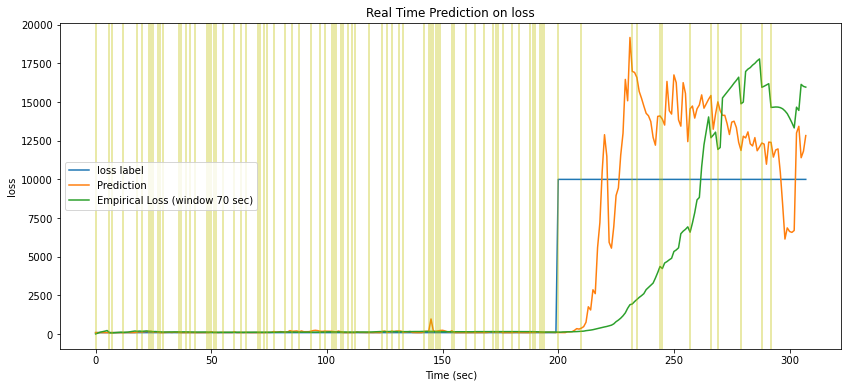

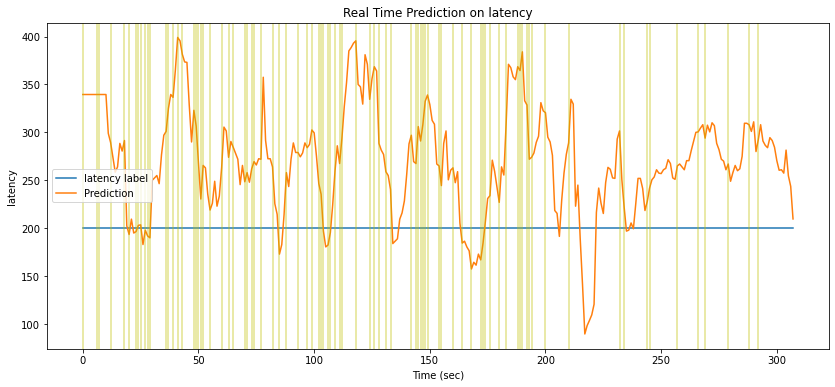

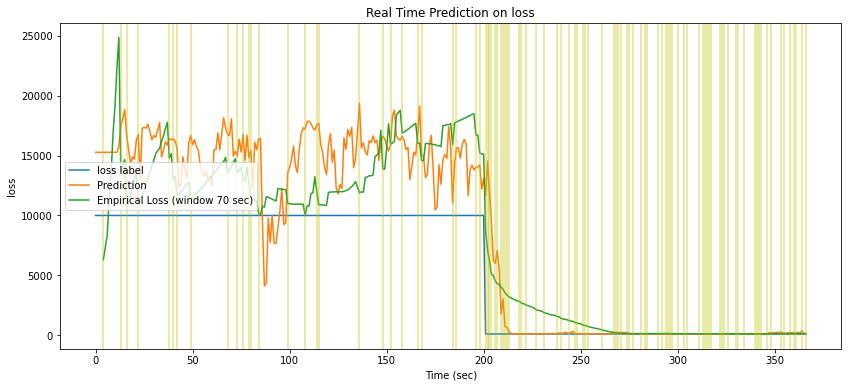

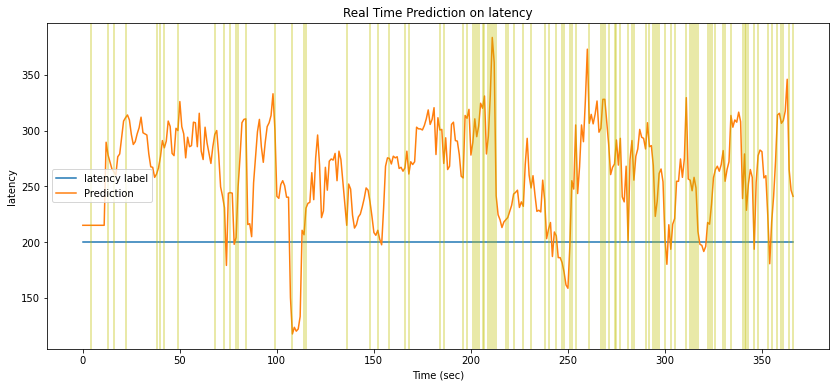

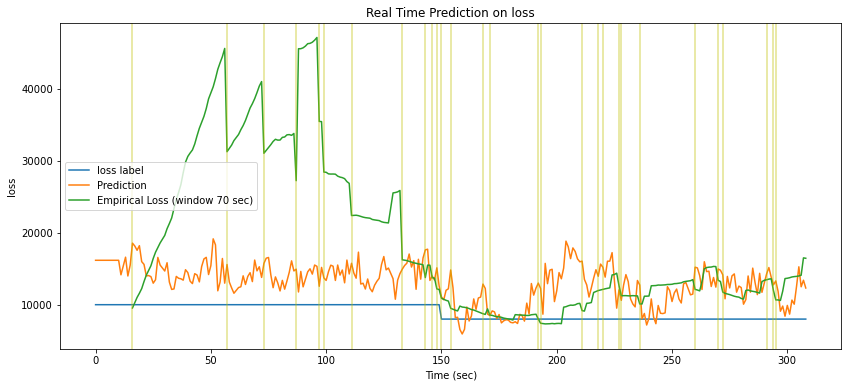

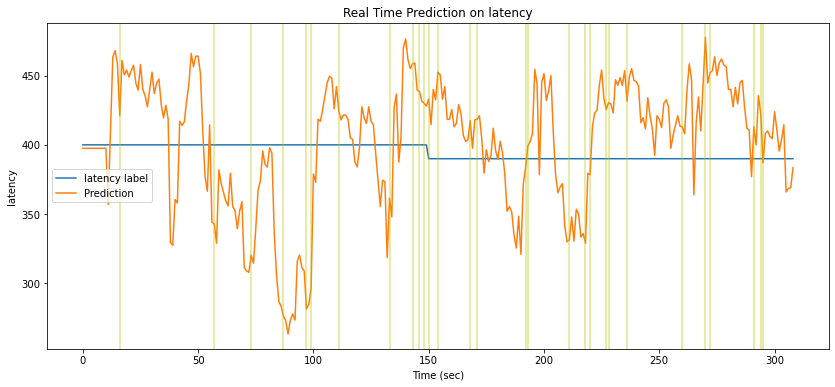

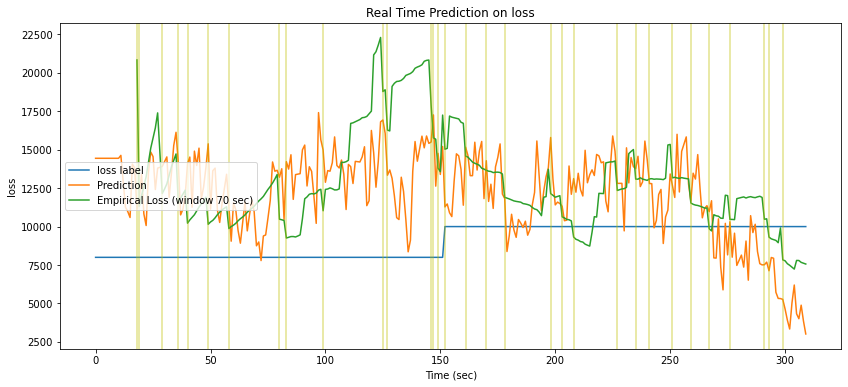

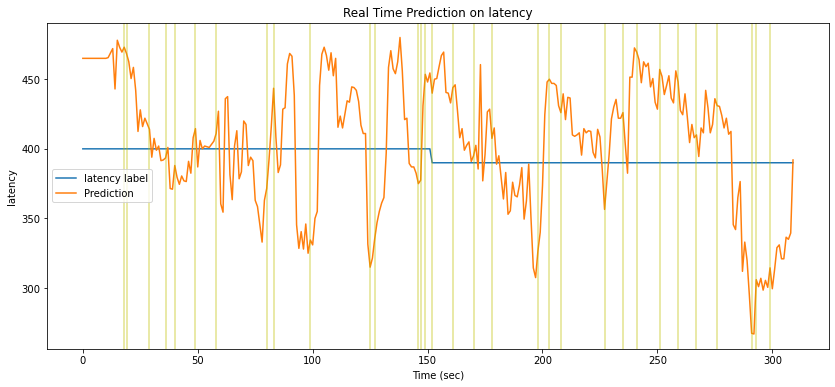

In [18]:
dir_ = 'data/jennawk5data'
lst = []
for i in [x for x in listdir(dir_) if not 'losslog' in x]:
    # the_csv_youre_using = listdir(dir_)

    mergedtable = readfilerun_simple(os.path.join(dir_, i), dir_) # merges losslog. make sure you have losslog in the same train_c directory
    df_ = genfeat(mergedtable) # generates all the adjacent features we train on!
    gen_model(df_, 'loss', 70)
    gen_model(df_, 'latency', 70)
    lst.append(df_)
lst[0]

In [19]:
lst[0]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction,pred_loss,pred_latency
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,0.000000,0,1,13724,1143.666667,0,1143.666667,339.5,681.5,486.0
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,13.694915,402,8,52520,875.333333,808,875.333333,339.5,137.5,453.5
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,7.400000,399,9,43456,776.000000,407,776.000000,339.5,118.0,392.0
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,12.656250,400,11,64196,987.630769,810,987.630769,339.5,101.5,387.5
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,9.878049,399,7,42728,1017.333333,405,1017.333333,339.5,109.0,356.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,0.583234,33,243,1831732,1096.189108,974,1096.189108,257.5,13000.0,257.5
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,0.675970,36,199,1598288,1087.270748,993,1087.270748,281.5,13430.0,281.5
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,0.493253,34,223,2189224,1093.518482,987,1093.518482,254.7,11400.0,254.7
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,0.554802,35,210,1907884,1077.291925,982,1077.291925,243.7,11820.0,243.7


In [20]:
# loss from 10000 to 100
loss10000to100 = lst[1]

<AxesSubplot:>

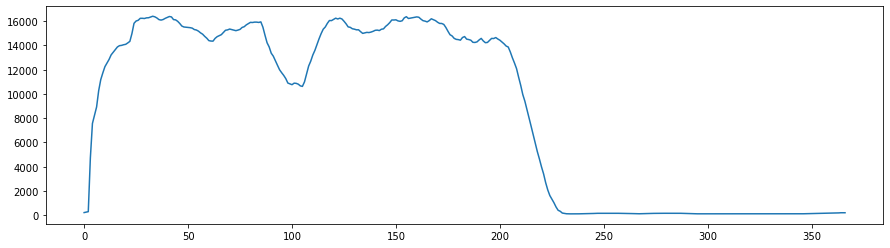

In [21]:
loss10000to100['pred_loss'].rolling(20, min_periods=1).mean().plot(figsize=(15,4))

<AxesSubplot:>

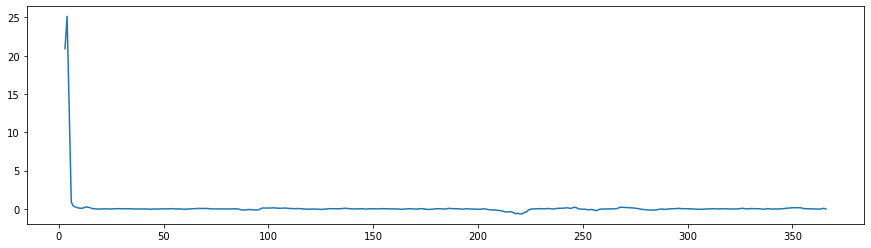

In [22]:
blah = lst[1]['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2) #.plot(figsize=(15,4))
blah.plot(figsize=(15,4))

<AxesSubplot:>

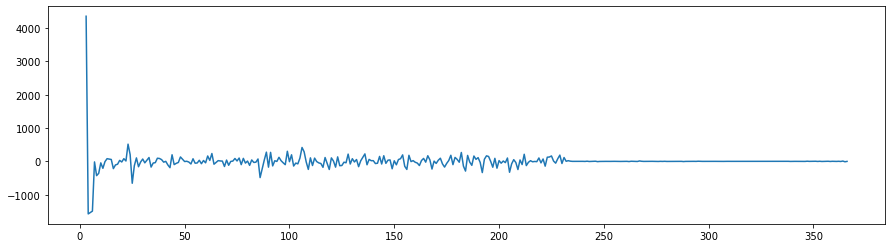

In [23]:
blah = lst[1]['pred_loss'].rolling(20, min_periods=1).mean().diff().diff()#.plot(figsize=(15,4))
blah.plot(figsize=(15,4))

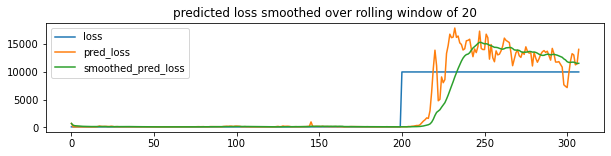

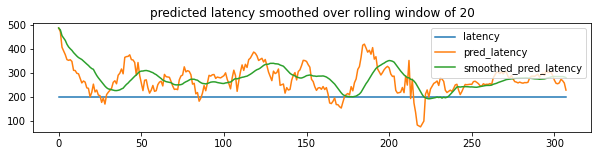

In [24]:
def plot_different_windowsizes(windowsize=20):
    tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
    tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
    tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
    tempdf[['loss', 'pred_loss', 'smoothed_pred_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
    tempdf[['latency', 'pred_latency', 'smoothed_pred_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))
plot_different_windowsizes()

In [25]:
loss10000to100['pctc2'] = loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2)
loss10000to100['pctc2_smooth'] = loss10000to100['pred_loss'].pct_change(2)
loss10000to100['pctc2']

0            NaN
2            NaN
3      20.935659
4      25.161193
6       0.892575
         ...    
362    -0.014022
363    -0.038276
364     0.027695
365     0.072746
366    -0.025249
Name: pctc2, Length: 360, dtype: float64

In [26]:
loss10000to100['pctc2'] <= 0.2

0      False
2      False
3      False
4      False
6      False
       ...  
362     True
363     True
364     True
365     True
366     True
Name: pctc2, Length: 360, dtype: bool

In [27]:
loss10000to100['loss']

0      10000
2      10000
3      10000
4      10000
6      10000
       ...  
362      100
363      100
364      100
365      100
366      100
Name: loss, Length: 360, dtype: int64

not looking for bad traffic
but traffic that is getting worse

In [28]:
loss10000to100[loss10000to100['pctc2'] <= -0.2].index

Int64Index([210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
            223, 256],
           dtype='int64')

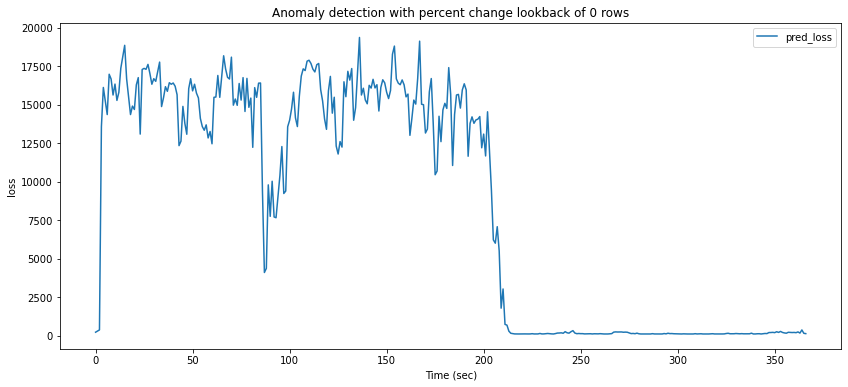

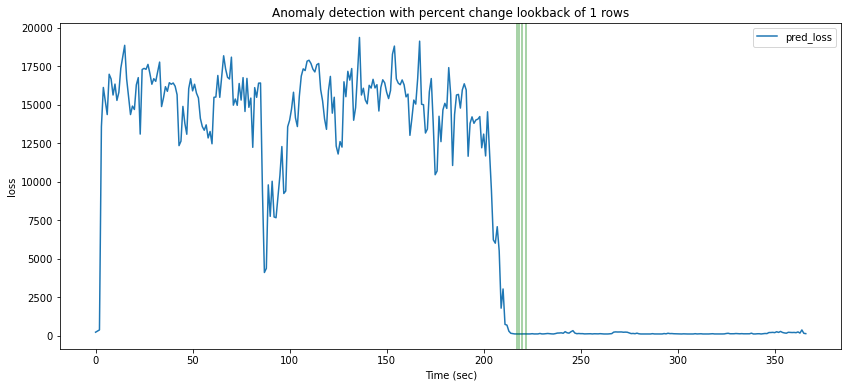

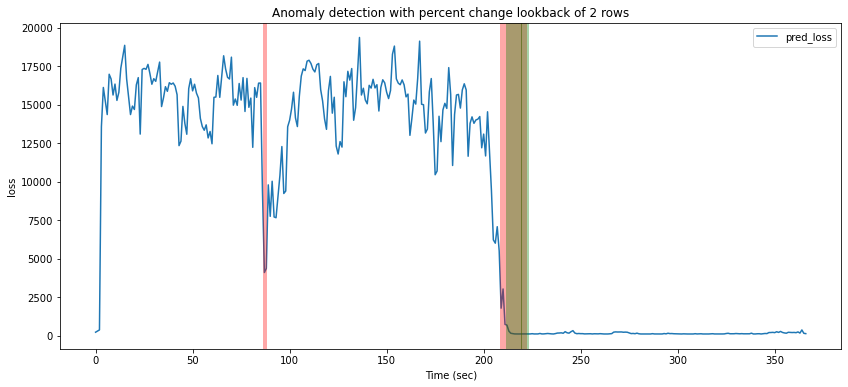

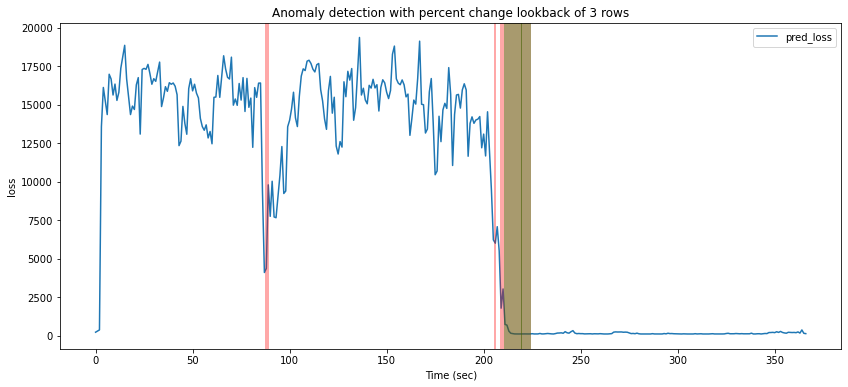

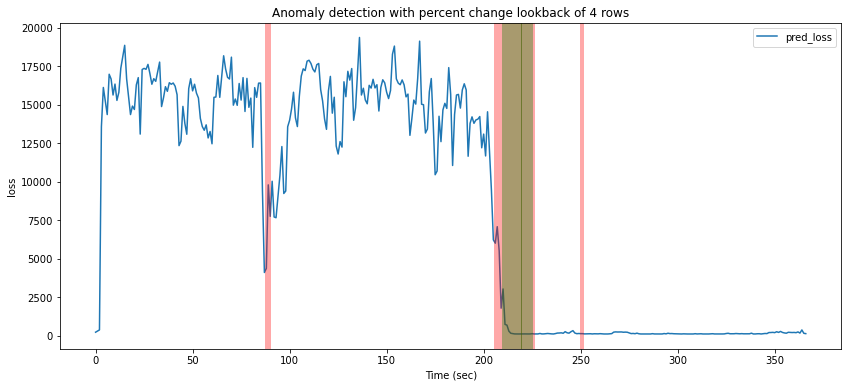

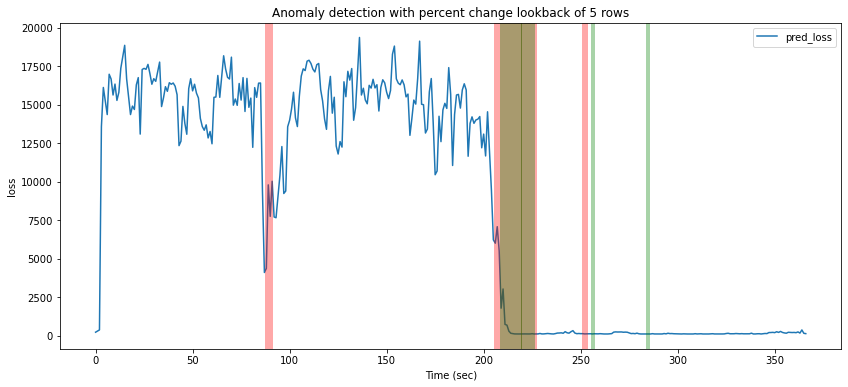

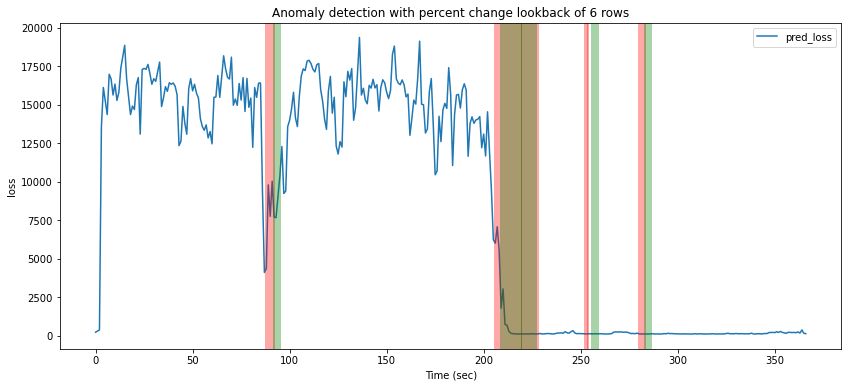

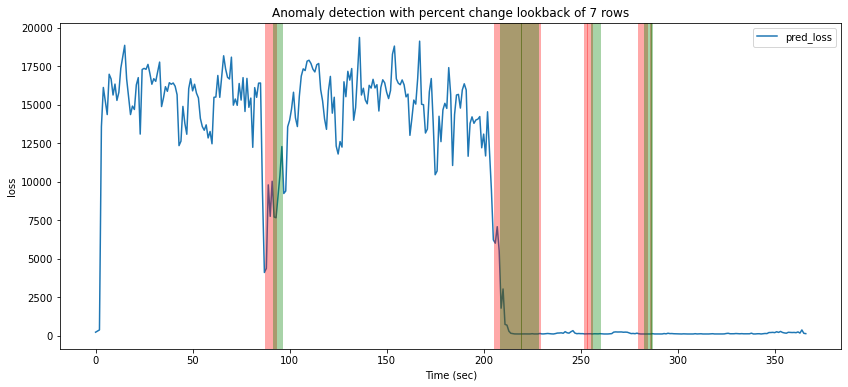

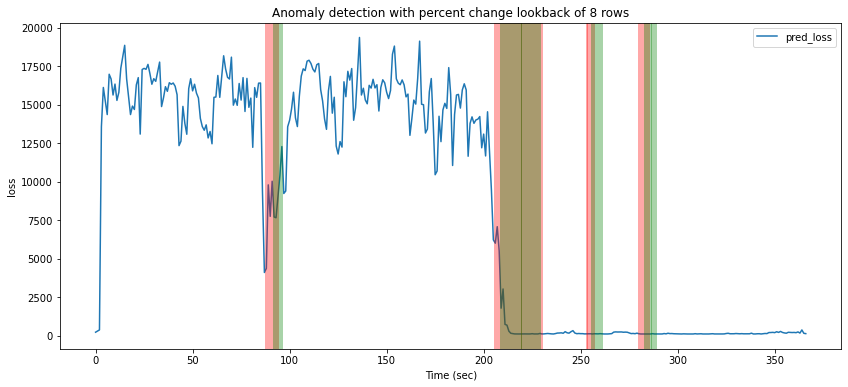

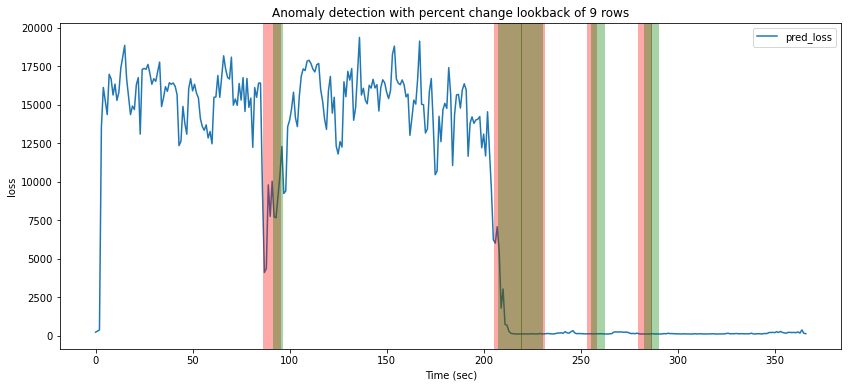

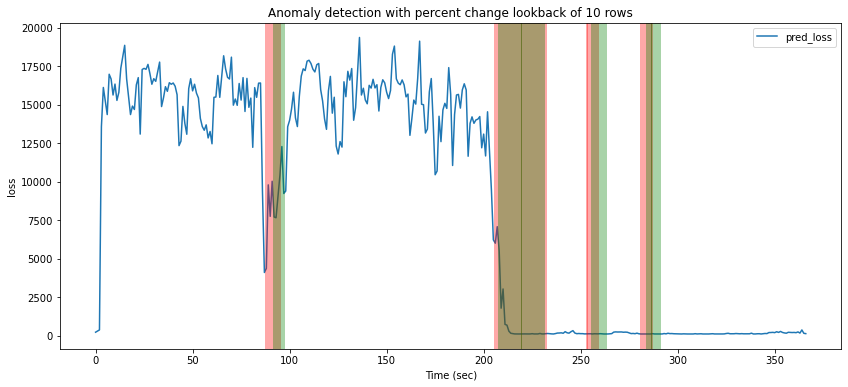

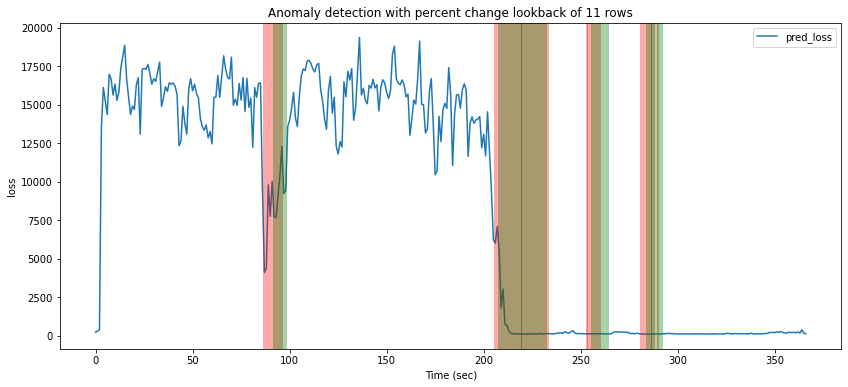

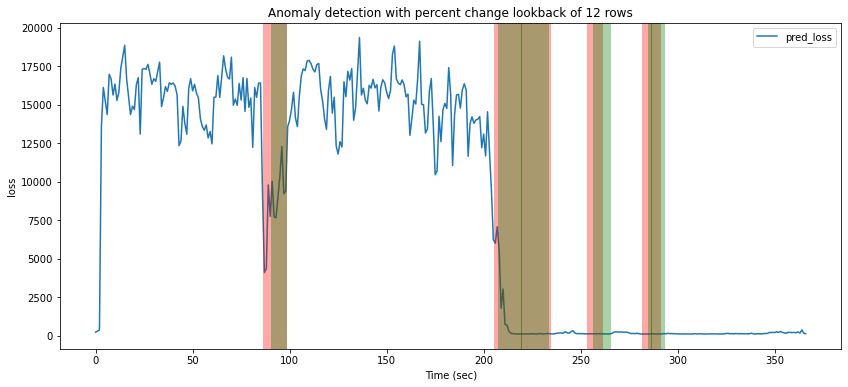

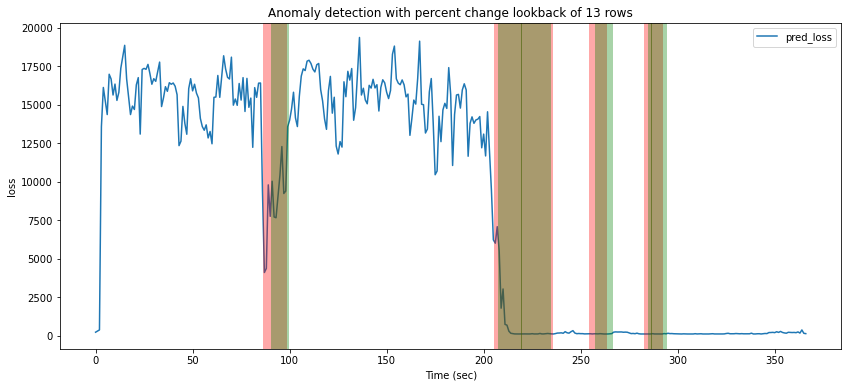

In [29]:

for pc in range(14):
    loss10000to100['pctc2'] = loss10000to100['pred_loss'].pct_change(pc)
    loss10000to100['pctc2_smooth'] = loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(pc)
    loss10000to100['pctc2_expsmooth'] = loss10000to100['pred_loss'].ewm(alpha=0.3, min_periods=1).mean().pct_change(pc)

    plt.figure(figsize=(14,6))
    loss10000to100['pred_loss'].plot(title=f'Anomaly detection with percent change lookback of {pc} rows', 
            xlabel='Time (sec)', ylabel='loss')
    plt.legend()
    for i in loss10000to100[loss10000to100['pctc2_expsmooth'] <= -0.3].index: # indices where negative percent change is higher than 0.3
        plt.axvline(x=i, color='r', alpha=.45)
    for i in loss10000to100[loss10000to100['pctc2_smooth'] <= -0.3].index: # indices where negative percent change is higher than 0.3
        plt.axvline(x=i, color='g', alpha=.45)

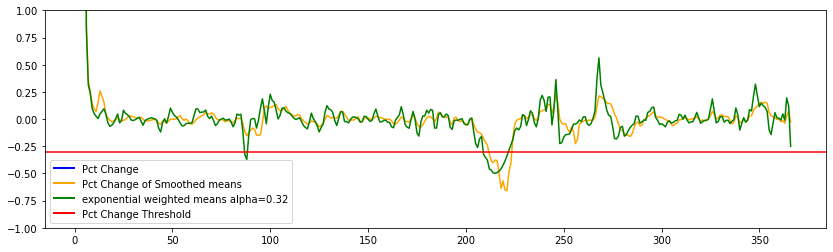

In [30]:
from matplotlib.lines import Line2D

alpha=0.32

plt.figure(figsize=(14,4))
plt.ylim((-1, 1))
# loss10000to100['pred_loss'].pct_change(2).plot(title='actual percent change', color='blue') # actual
loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2).plot(color='orange') # rolling mean 
loss10000to100['pred_loss'].ewm(alpha=alpha, min_periods=1).mean().pct_change(2).plot(color='green') # exp rolling mean
plt.axhline(-0.3, color='r')
custom_lines = [Line2D([0], [0], color='blue', lw=2), 
                Line2D([0], [0], color='orange', lw=2), 
                Line2D([0], [0], color='green', lw=2), 
                Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_lines, ['Pct Change', 'Pct Change of Smoothed means', f'exponential weighted means alpha={alpha}', 'Pct Change Threshold'])
# for i in loss10000to100[loss10000to100['pctc2'] <= -0.3].index: # indices where negative percent change is higher than 0.3
#     plt.axvline(x=i, color='r', alpha=.45)

In [31]:
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Staro\\.conda\\envs\\sklearn\\lib\\site-packages\\matplotlib\\pyplot.py'>

<AxesSubplot:>

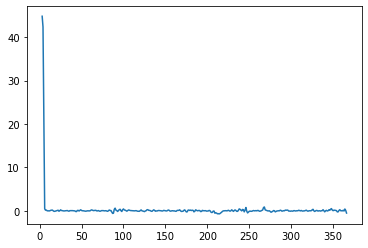

In [32]:
loss10000to100['pred_loss'].ewm(alpha=0.7, min_periods=1).mean().pct_change(2).plot()

<AxesSubplot:>

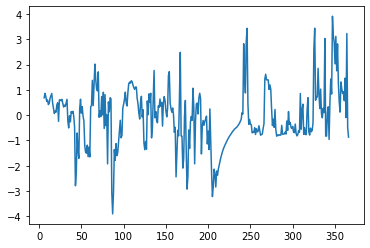

In [33]:
loss10000to100['pred_loss'].rolling(30, min_periods=5).apply(lambda x: (x.tail(1) - x.mean())/x.std()).plot()

In [34]:
loss10000to100['packet_dirs']

0      [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, ...
2      [2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, ...
3      [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
4      [2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, ...
6      [2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, ...
                             ...                        
362    [2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, ...
363    [2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, ...
364    [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
365    [2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, ...
366    [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
Name: packet_dirs, Length: 360, dtype: object

In [35]:
loss10000to100['packet_times']

0      [1643677661114, 1643677661114, 1643677661115, ...
2      [1643677662324, 1643677662324, 1643677662324, ...
3      [1643677663134, 1643677663134, 1643677663134, ...
4      [1643677664000, 1643677664000, 1643677664000, ...
6      [1643677665183, 1643677665183, 1643677665183, ...
                             ...                        
362    [1643678016046, 1643678016046, 1643678016085, ...
363    [1643678017029, 1643678017029, 1643678017029, ...
364    [1643678018065, 1643678018065, 1643678018065, ...
365    [1643678019051, 1643678019051, 1643678019051, ...
366    [1643678020036, 1643678020036, 1643678020036, ...
Name: packet_times, Length: 360, dtype: object

In [43]:
mergedtable['packet_dirs']

0                               2;1;1;1;1;1;1;1;1;1;1;1;
1      2;1;1;2;1;1;2;1;1;2;2;1;1;2;1;2;1;2;1;2;2;1;2;...
2      2;1;2;2;1;1;2;2;1;1;2;2;1;1;2;2;1;1;2;2;1;1;2;...
4      2;1;2;2;1;1;2;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;1;...
5      2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;...
                             ...                        
303    2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;1;1;1;2;1;1;2;1;...
304    2;1;1;2;1;1;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;...
305    2;1;1;1;1;1;1;1;2;1;1;1;1;2;1;1;2;1;1;2;1;1;2;...
306    2;1;1;1;1;2;1;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;...
307    2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;1;2;1;1;2;...
Name: packet_dirs, Length: 302, dtype: object

In [51]:
value=2
mergedtable[f'{value}_idx'] = mergedtable['packet_dirs'].str.replace(';', '').apply(lambda x: [i for i, j in enumerate(x) if j == str(value)])
# mergedtable['packet_dirs'].str.replace('2;', '0').str.replace('1;', '1').apply(lambda x: [i for i, j in enumerate(x) if j == "0"])

0                                                    [0]
1      [0, 3, 6, 9, 10, 13, 15, 17, 19, 20, 22, 24, 2...
2      [0, 2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23...
4      [0, 2, 3, 6, 7, 10, 13, 16, 19, 23, 26, 29, 32...
5      [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 3...
                             ...                        
303    [0, 3, 6, 9, 12, 18, 21, 24, 27, 30, 33, 36, 3...
304    [0, 3, 8, 11, 14, 17, 20, 23, 26, 29, 33, 36, ...
305    [0, 8, 13, 16, 19, 22, 25, 28, 33, 36, 41, 46,...
306    [0, 5, 9, 12, 15, 18, 21, 26, 29, 32, 35, 40, ...
307    [0, 3, 6, 9, 12, 15, 19, 22, 25, 28, 31, 34, 3...
Name: packet_dirs, Length: 302, dtype: object

In [84]:
def mean_diff_dir(lst):
    '''
    returns mean difference in a column, 
    meant to be used on transformed 'packet_times' column
    >>> df['packet_times'].str.split(';').apply(mean_diff)
    '''
    # lst = np.array(list(filter(None, lst))) # takes out empty strings
    temp = np.array(list(map(int, lst)))
    # print(temp)
    mn = np.mean(np.diff(temp))
    return 0 if np.isnan(mn) else mn

In [94]:
output = mergedtable.apply(lambda x: [h for g, h in enumerate(x['packet_times'].split(';')) if g in [i for i, j in enumerate(x['packet_dirs'].replace(';','')) if j == str(1)]], axis=1).apply(mean_diff_dir)#.plot()
output2 = mergedtable.apply(lambda x: [h for g, h in enumerate(x['packet_times'].split(';')) if g in [i for i, j in enumerate(x['packet_dirs'].replace(';','')) if j == str(2)]], axis=1).apply(mean_diff_dir)#.plot()
output

0       0.000000
1      24.484848
2      15.074074
4      19.756098
5      15.000000
         ...    
303     0.808970
304     0.945714
305     0.685893
306     0.783719
307     0.620584
Length: 302, dtype: float64

In [54]:
mergedtable.columns

Index(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'packet_times', 'packet_sizes',
       'packet_dirs', 'event', 'drop_unix', 'latency', 'loss', 'later_latency',
       'later_loss', 'deterministic', 'switch_label'],
      dtype='object')

In [88]:
df.columns

Index(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'packet_times', 'packet_sizes',
       'packet_dirs', 'event', 'drop_unix', 'latency', 'loss', 'later_latency',
       'later_loss', 'deterministic', 'switch_label', 'total_bytes',
       'total_pkts', 'pkt sum', 'longest_seq', 'mean_tdelta', 'max_tdelta',
       'number_ms', 'total_pkt_sizes', 'pkt_ratio', 'time_spread',
       'byte_ratio'],
      dtype='object')

<AxesSubplot:>

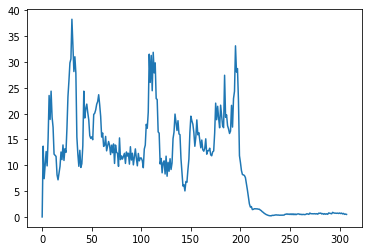

In [89]:
df['mean_tdelta'].plot()

In [92]:
output.plot()

[]

In [93]:
output2.plot()

[]